In [ ]:
Both Implementations here 

# Kalman Filter 

In [18]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt

In [13]:
def simulate_trajectory(pos, speed, angle, dt, steps):
    g = 9.81  # earth gravity constant
    theta = np.radians(angle)  # convert launch angle to radians
    vx0 = speed * np.cos(theta)  # initial horizontal velocity
    vy0 = speed * np.sin(theta)  # Initial vertical velocity

    traj = np.zeros((steps, 2))  # array to store positions
    traj[0] = pos  # set initial position

    for i in range(1, steps):
        traj[i, 0] = traj[i - 1, 0] + vx0 * dt  # update horizontal position
        traj[i, 1] = traj[i - 1, 1] + vy0 * dt  # update vertical position
        vy0 -= g * dt  # update vertical velocity due to gravity

        if traj[i, 1] < 0:
            traj[i, 1] = 0  # set y-coordinate to 0 if the ball hits the ground ---> to avoid the bounc off of course its based on the size and weight of the ball which here I didn't include it.
            break  # exit the loop

    return traj[:i+1]  # return the trajectory up to the point the ball hits the ground



In [14]:
def generate_observation(true_traj, obs_error):
    steps, _ = true_traj.shape
    observed_traj = true_traj + np.random.normal(0, obs_error, size=(steps, 2))
    return observed_traj

In [15]:
def kalman(observed_traj, dt, init_state, init_cov, proc_noise, obs_noise):
    steps, _ = observed_traj.shape
    state_size = 4  # Size of the state vector

    # Initial state
    x = init_state.copy()

    # Initial covariance matrix
    P = init_cov.copy()

    # Observation matrix
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    # simulation
    estimated_traj = []

    for i in range(steps):
        # simulate measurement
        observed = observed_traj[i]

        # update step
        # predict
        x[0] = x[0] + x[2] * dt  # update horizontal position prediction
        x[1] = x[1] + x[3] * dt  # update vertical position prediction
        x[3] -= 9.81 * dt  # update vertical velocity prediction due to gravity

        # update covariance
        F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        P = F @ P @ F.T + proc_noise  # Update covariance matrix prediction

        # Correct
        y = observed - H @ x  # calculate residual (difference between observed and predicted)
        S = H @ P @ H.T + obs_noise  # innovation covariance
        K = P @ H.T @ np.linalg.inv(S)  # Kalman gain
        x = x + K @ y  # update state estimate
        P = (np.eye(state_size) - K @ H) @ P  # update covariance matrix

        # save estimated position
        estimated_traj.append(x[:2])

    return np.array(estimated_traj)

In [16]:
# user parameters
dt = 0.01  # s, time step size
steps = 1000  # number of simulation steps

pos = np.array([0, 0], dtype=float)  # initial position of the ball
speed = 30  # initial speed of the ball
angle = 45  # launch angle of the ball

obs_error = 1  # Observation error (standard deviation)
obs_time_span = 1  # s, observation time span
obs_dropout = 0.01  # Probability of an observation being dropped

init_state = np.array([0, 0, speed * np.cos(np.radians(angle)), speed * np.sin(np.radians(angle))])
init_cov = np.eye(4) * 1  # initial covariance matrix
proc_noise = np.array([
    [dt ** 4 / 4, 0, dt ** 3 / 2, 0],
    [0, dt ** 4 / 4, 0, dt ** 3 / 2],
    [dt ** 3 / 2, 0, dt ** 2, 0],
    [0, dt ** 3 / 2, 0, dt ** 2]
]) * 0.001 ** 2  # process noise covariance matrix
obs_noise = np.eye(2) * obs_error ** 2  # Observation noise covariance matrix

true_traj = simulate_trajectory(pos, speed, angle, dt, steps)  # simulate true ball trajectory
observed_traj = generate_observation(true_traj, obs_error)  # simulate observed ball trajectory

dropout_mask = np.random.random(observed_traj.shape[0]) >= obs_dropout  # mask for observation dropout
observed_traj = observed_traj[dropout_mask]  # apply observation dropout

time_span_mask = np.random.random(len(observed_traj)) <= obs_time_span / dt  # mask for variable observation time span
observed_traj = observed_traj[time_span_mask]  # apply variable observation time span

estimated_traj = kalman(observed_traj, dt, init_state, init_cov, proc_noise, obs_noise)[:len(observed_traj)]  # Kalman filter estimation

error = estimated_traj - true_traj[:len(estimated_traj)]  # calculate estimation error
rmse = np.sqrt(np.mean(error[:, 0]**2 + error[:, 1]**2))  # calculate RMSE (Root Mean Square Error)

estimated_vel = np.gradient(estimated_traj, dt, axis=0)  # estimate velocity
true_vel = np.gradient(true_traj, dt, axis=0)  # true velocity

#print(f"RMSE: {rmse:.2f}")  # print RMSE


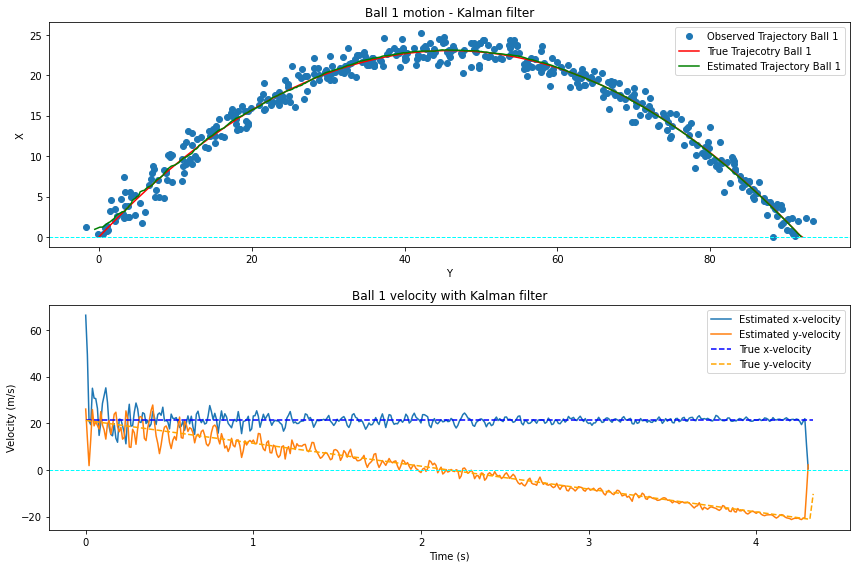

In [17]:
#plotting 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))  # create subplots for visualization

ax1.plot(observed_traj[:, 0], observed_traj[:, 1], 'o', label='Observed Trajectory Ball 1')  # plot observed trajectory
ax1.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajecotry Ball 1', color='red')  # plot true trajectory
ax1.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='Estimated Trajectory Ball 1', color='green')  # plot estimated trajectory
ax1.set_xlabel('Y')  # set x-axis label
ax1.set_ylabel('X')  # set y-axis label
ax1.set_title('Ball 1 motion - Kalman filter')  # set plot title

ax1.legend() 

ax2.plot(np.arange(len(estimated_vel)) * dt, estimated_vel[:, 0], label='Estimated x-velocity')  # plot estimated x-velocity
ax2.plot(np.arange(len(estimated_vel)) * dt, estimated_vel[:, 1], label='Estimated y-velocity')  # plot estimated y-velocity
ax2.plot(np.arange(len(true_vel)) * dt, true_vel[:, 0], label='True x-velocity', linestyle='--', color='blue')  # plot true x-velocity
ax2.plot(np.arange(len(true_vel)) * dt, true_vel[:, 1], label='True y-velocity', linestyle='--', color='orange')  # plot true y-velocity

ax2.set_xlabel('Time (s)')  # set x-axis label
ax2.set_ylabel('Velocity (m/s)')  # set y-axis label
ax2.set_title('Ball 1 velocity with Kalman filter')  # set plot title
ax2.legend()  

ax1.axhline(0, color='cyan', linestyle='--', linewidth=1)  # add vertical line at x=0 (ground line)
ax2.axhline(0, color='cyan', linestyle='--', linewidth=1)  # add horizontal line at y=0 (ground line)

plt.tight_layout()  

plt.show()  

# Particle Filter 

In [ ]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def simulate_ball_trajectory(launch_pos, launch_speed, launch_angle, dt, ground_level, num_steps):
    # simulates the true trajectory of a ball
    trajectory = np.zeros((num_steps, 4))  # [x, vx, y, vy]
    trajectory[0] = [launch_pos[0], launch_speed * np.cos(np.radians(launch_angle)),
                     launch_pos[1], launch_speed * np.sin(np.radians(launch_angle))]

    for i in range(1, num_steps):
        x, vx, y, vy = trajectory[i - 1]

        # Update x position and velocity
        trajectory[i, 0] = x + vx * dt
        trajectory[i, 1] = vx

        # Update y position and velocity
        trajectory[i, 2] = y + vy * dt
        trajectory[i, 3] = vy - 9.8 * dt

        # Check if ball hits the ground
        if trajectory[i, 2] <= ground_level:
            trajectory[i, 2] = ground_level
            trajectory[i, 3] = 0  # Set vertical velocity to zero when ball reaches the ground
            break  # Exit the loop when ball reaches the ground

    # trim trajectory to the actual number of steps taken
    trajectory = trajectory[:i+1]

    return trajectory

In [19]:
def simulate_observation(true_trajectory, observation_error, dt, observation_drop_prob):
    # simulates the observed trajectory with noise and dropped observations
    num_steps = len(true_trajectory)
    observed_trajectory = np.zeros_like(true_trajectory)

    for i in range(num_steps):
        if np.random.rand() > observation_drop_prob:  # Simulate dropped observations
            true_state = true_trajectory[i]
            observed_trajectory[i] = true_state + np.random.normal(0, observation_error, size=(4,))

    return observed_trajectory

In [20]:
def run_particle_filter(observed_trajectory, dt, process_error, observation_error, num_particles):
    num_steps = len(observed_trajectory)
    num_states = observed_trajectory.shape[1]

    # initialize particles
    particles = np.zeros((num_steps, num_particles, num_states))
    particles[0] = np.tile(observed_trajectory[0], (num_particles, 1)) + np.random.normal(0, process_error, size=(num_particles, num_states))

    for i in range(1, num_steps):
        # predict step
        particles[i] = particles[i - 1] + np.random.normal(0, process_error, size=(num_particles, num_states))

        # update step
        weights = calculate_weights(particles[i], observed_trajectory[i], observation_error)
        indices = systematic_resampling(weights)
        particles[i], _ = resample_particles(particles[i], indices)

    # Calculate estimated trajectory
    estimated_trajectory = np.mean(particles, axis=1)

    return estimated_trajectory, particles

In [ ]:
def calculate_weights(particles, observation, observation_error):
    num_particles = particles.shape[0]
    weights = np.zeros(num_particles)

    for i in range(num_particles):
        diff = particles[i] - observation
        likelihood = np.exp(-0.5 * np.sum(diff ** 2) / observation_error ** 2)
        weights[i] = likelihood

    # normalize weights
    sum_weights = np.sum(weights)
    if sum_weights != 0:
        weights /= sum_weights
    else:
        weights[:] = 1 / num_particles

    return weights

In [21]:
def systematic_resampling(weights):
    num_particles = weights.shape[0]
    cumulative_weights = np.cumsum(weights)
    indices = np.zeros(num_particles, dtype=int)
    u = np.random.uniform(0, 1 / num_particles)
    j = 0

    for i in range(num_particles):
        while u > cumulative_weights[j]:
            j += 1
        indices[i] = j
        u += 1 / num_particles

    return indices

In [22]:
def resample_particles(particles, indices):
    num_particles = particles.shape[0]
    num_states = particles.shape[1]
    new_particles = np.zeros_like(particles)

    for i in range(num_particles):
        new_particles[i] = particles[indices[i]]

    new_weights = np.ones(num_particles) / num_particles

    return new_particles, new_weights

In [23]:
# User parameters
launch_pos = [0, 0]
launch_speed = 30
launch_angle = 45
dt = 0.01
ground_level = 0
num_steps = 1000
observation_error = 1
observation_drop_prob = 0.01
process_error = 0.5
num_particles = 1000

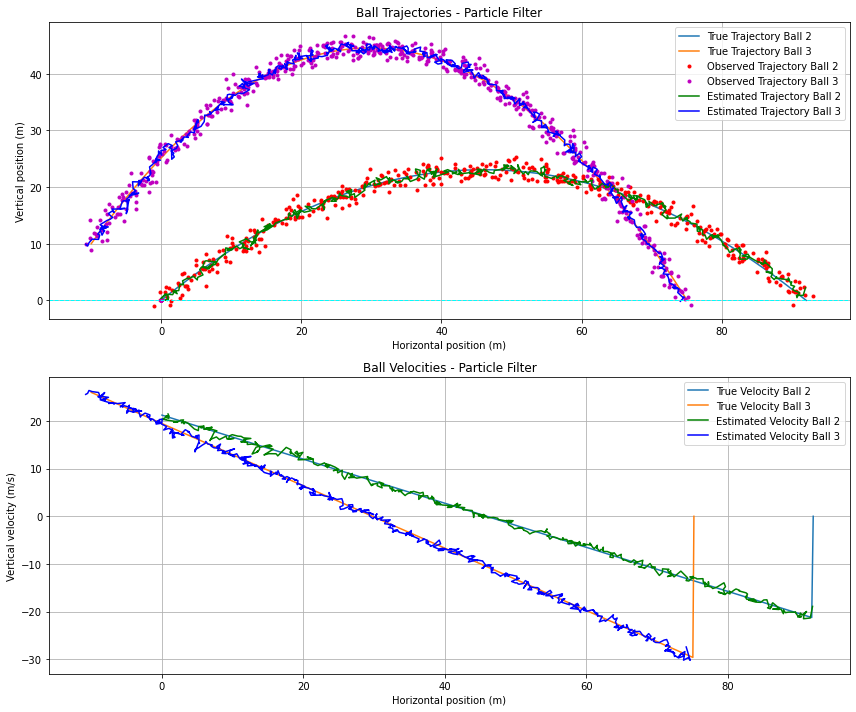

In [10]:
#plotting

# simulate true ball trajectory
true_trajectory1 = simulate_ball_trajectory(launch_pos, launch_speed, launch_angle, dt, ground_level, num_steps)
true_trajectory2 = simulate_ball_trajectory([-10, 10], launch_speed, 60, dt, ground_level, num_steps)

# simulate observed trajectory with noise and dropped observations
observed_trajectory1 = simulate_observation(true_trajectory1, observation_error, dt, observation_drop_prob)
observed_trajectory2 = simulate_observation(true_trajectory2, observation_error, dt, observation_drop_prob)

# run the Particle Filter (Condensation Algorithm)
estimated_trajectory1, particles1 = run_particle_filter(observed_trajectory1, dt, process_error, observation_error,
                                                       num_particles)
estimated_trajectory2, particles2 = run_particle_filter(observed_trajectory2, dt, process_error, observation_error,
                                                       num_particles)

# plotting trajectories and velocities
plt.figure(figsize=(12, 10))

# plotting trajectories
plt.subplot(2, 1, 1)
plt.plot(true_trajectory1[:, 0], true_trajectory1[:, 2], label='True Trajectory Ball 2')
plt.plot(true_trajectory2[:, 0], true_trajectory2[:, 2], label='True Trajectory Ball 3')
plt.plot(observed_trajectory1[:, 0], observed_trajectory1[:, 2], 'r.', label='Observed Trajectory Ball 2')
plt.plot(observed_trajectory2[:, 0], observed_trajectory2[:, 2], 'm.', label='Observed Trajectory Ball 3')
plt.plot(estimated_trajectory1[:, 0], estimated_trajectory1[:, 2], 'g-', label='Estimated Trajectory Ball 2')
plt.plot(estimated_trajectory2[:, 0], estimated_trajectory2[:, 2], 'b-', label='Estimated Trajectory Ball 3')

plt.axhline(0, color='cyan', linestyle='--', linewidth=1)  # Add horizontal line at y=0 (ground line)
plt.xlabel('Horizontal position (m)')
plt.ylabel('Vertical position (m)')
plt.title('Ball Trajectories - Particle Filter')
plt.legend(loc='upper right', frameon=True)
plt.grid(True)

# plotting velocities
plt.subplot(2, 1, 2)
plt.plot(true_trajectory1[:, 0], true_trajectory1[:, 3], label='True Velocity Ball 2')
plt.plot(true_trajectory2[:, 0], true_trajectory2[:, 3], label='True Velocity Ball 3')
#plt.plot(observed_trajectory1[:, 0], observed_trajectory1[:, 3], 'r.', label='Observed Velocity Ball 2')
#plt.plot(observed_trajectory2[:, 0], observed_trajectory2[:, 3], 'm.', label='Observed Velocity Ball 3')
plt.plot(estimated_trajectory1[:, 0], estimated_trajectory1[:, 3], 'g-', label='Estimated Velocity Ball 2')
plt.plot(estimated_trajectory2[:, 0], estimated_trajectory2[:, 3], 'b-', label='Estimated Velocity Ball 3')

plt.xlabel('Horizontal position (m)')
plt.ylabel('Vertical velocity (m/s)')
plt.title('Ball Velocities - Particle Filter')
plt.legend(loc='upper right', frameon=True)
plt.grid(True)

plt.tight_layout()
plt.show()
